# Python Analytics Project: Analysis of the experiment results on the website

## Problem

We have the result of __A/B testing__. During the testing of one hypothesis, the target group was offered a new mechanics of paying for services on the site, the control group remained with the basic mechanics. It is necessary to analyze the results of the experiment and conclude whether it is worth launching a new payment mechanism for all users or not.

## Data
There are four tables, and their names and column definitions are listed below:

### Table 1: groups
_This table contains information about the user's membership in a control or experimental group (A – control, B – target group)_

__id__ - identification code of user;

__grp__ - group membership (A – control, B – target group)

### Table 2: groups_add
_An additional file to the first table_

__id__ - identification code of user;

__grp__ - group membership (A – control, B – target group)

### Table 3: active_studs
_This table include information about users who logged on to the platform during the experiment_

__student_id__ - identification code of user

### Table 4: checks
_This table contains information about user payments during the experiment_

__student_id__ - identification code of user;

__rev__ - sum of payments

## Analysis

In [1]:
# importing libraries
import pandas as pd
import seaborn as sns
import numpy as np
import pingouin as pg
import scipy.stats as ss
from tqdm.auto import tqdm
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandahouse as ph
from scipy.stats import levene
from scipy.stats import ttest_ind
%matplotlib inline

First of all let's take a look at the appearence of these tables and pre-process the data

In [2]:
# reading tables and saving to dataframe
groups_1 = pd.read_csv('Проект_2_groups.csv', sep=';')
groups_2 = pd.read_csv('Проект_2_group_add.csv', sep=',')
active_studs = pd.read_csv('Проект_2_active_studs.csv')
checks = pd.read_csv('Проект_2_checks.csv', sep=';')

In [3]:
groups_1.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups_2.head()

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [5]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [6]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [7]:
# combining files with users
group = pd.concat([groups_1, groups_2])

Let's check the data in every table for duplicates

In [8]:
checks.loc[checks.duplicated()]

,student_id,rev


In [9]:
active_studs.loc[active_studs.duplicated()]

,student_id


In [10]:
group.loc[group.duplicated()]

,id,grp


There are no duplicated values

Let's combine all dataframes to check if there are any errors in the data

In [11]:
# we will add a new column in the table with active users for convenience
active_studs['status'] = 'active'

In [12]:
# combining dataframes
total = checks.merge(active_studs, how = 'outer', on = 'student_id')
group = group.rename(columns={'id':'student_id'})
total = total.merge(group, how = 'inner', on = 'student_id')

In [13]:
total

,student_id,rev,status,grp
0,1627,990.0,active,A
1,3185,690.0,NaN,B
2,25973,690.0,NaN,B
3,26280,690.0,NaN,B
4,100300,990.0,active,B
...,...,...,...,...
8485,264371,NaN,active,B
8486,1794344,NaN,active,B
8487,296883,NaN,active,B
8488,3598448,NaN,active,B


We can see that there is data about students who made a purchase, but for some reason they did not get into the file with information about users who entered the platform on the days of the experiment. I think this is a system bug, and these users also need to be classified as active, because they could not make a purchase without visiting the site

During the analysis, first of all, I will consider and compare __the conversion to purchase__ of different groups of users, since this indicator helps to understand if the share of users who made a purchase increased during the experiment

To calculate the conversion, I will take into account only active users who visited the site during the experiment and who could be affected by a change in the mechanics of payment

In [14]:
# determining the conversion to purchase of the control group
CR_A = total.query('grp == "A"').query('rev > 0').shape[0] / total.query('grp == "A"').shape[0] * 100
CR_A

6.828334396936822

In [15]:
# determining the conversion to purchase of the target group
CR_B = total.query('grp == "B"').query('rev > 0').shape[0] / total.query('grp == "B"').shape[0] * 100
CR_B

6.268958543983821

It can be noticed that the conversion to purchase is almost the same for both groups of users, slightly less for the experimental group. This may indicate that the change in the mechanics of payment in the end did not affect users in any way and did not increase the number of purchases. But it's too early to draw conclusions. There may have been a change in their amounts

We do not have exact information about what changes were made in the payment mechanics. Perhaps in the first version, when the user wanted to make a repeat purchase, his card data was not saved and the data had to be re-entered, this could stop the user from making a repeat purchase. To check the changes in the purchase amounts, let's calculate __ARPU (average income per paying user)__

In [16]:
# determing average income per paying user in the control group
ARPPU_A = total.query('grp == "A"').query('rev > 0').rev.sum() / total.query('grp == "A"').query('rev > 0').shape[0]
ARPPU_A

860.7102803738318

In [17]:
# determing average income per paying user in the target group
ARPPU_B = total.query('grp == "B"').query('rev > 0').rev.sum() / total.query('grp == "B"').query('rev > 0').shape[0]
ARPPU_B

1108.8248930875575

Thus, despite the fact that the conversion to purchase remained unchanged, the revenue per user who made a purchase increased

To make sure that the AB test and experiment affected the income, let's conduct __a statistical analysis__.  
For the 0 hypothesis, I take the fact that the results in the two groups are the same. It is necessary to look at the distribution, select a test and check the significance of the differences

First, let's check how the data is distributed in both groups

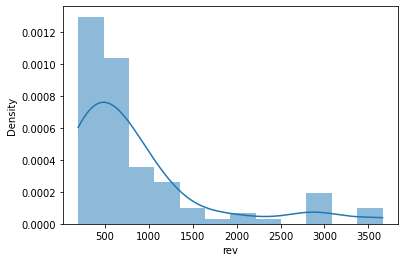

In [18]:
# control group data distribution graph
sns.histplot(total[total.grp == 'A'].rev, kde=True, stat="density", linewidth=0)

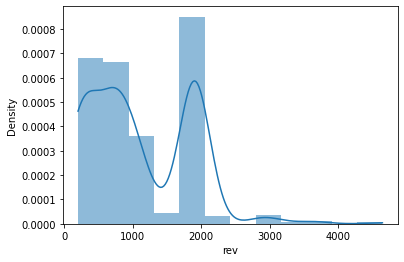

In [19]:
# target group data distribution graph
sns.histplot(total[total.grp == 'B'].rev, kde=True, stat="density", linewidth=0)

Judging by the graphs, the distribution deviates from normal

In [20]:
# normality test
pg.normality(data = total, dv = 'rev', group = 'grp', method = 'normaltest')

,W,pval,normal
A,52.218452,4.580439e-12,False
B,33.195875,6.188814e-08,False


The test also confirms that the distribution deviates from normal

Let's check whether the dispersions in the two groups are the same to see if it is possible to conduct a t-test. Since the data is distributed abnormally, I use the Levene test for this

In [21]:
# data preprocessing
control = total.query('grp == "A"').query('rev > 0').rev
test = total.query('grp == "B"').query('rev > 0').rev

In [22]:
# Levene test
stat, p = levene(control, test, center='median')
p

0.03477352573759214

According to the results of the test p-value <0.5, it means that the dispersions in the two groups differ significantly from each other, in this case, the t-test may show inadequate results, it is better to not use it. The Mann–Whitney test is also not suitable here, since there are many duplicate values in the data

In this case, it is better to use the Bootstrap method

In [23]:
def get_bootstrap(
    control, # numeric values of the first sample
    test, # numeric values of the second sample
    boot_it = 1000, # number of bootstrap subsamples
    statistic = np.mean,
    bootstrap_conf_level = 0.95 # significance level
):
    boot_data = []
    for i in tqdm(range(boot_it)): # extracting subsamples
        samples_1 = control.sample(
            len(control), 
            replace = True # return parameter
        ).values
        
        samples_2 = test.sample(
            len(control), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - applying statistics
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
        # visualization
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

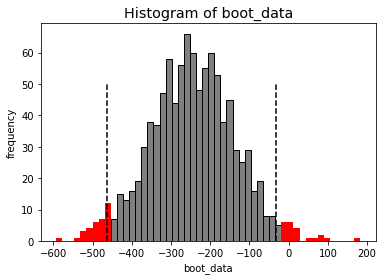

In [24]:
# building a histogram based on bootstrapped data
booted_data = get_bootstrap(control, test)

In [25]:
# determing p-value
booted_data["p_value"]

0.02289003325706992

In [26]:
# determing the confidence interval
booted_data["quants"]

,0
0.025,-463.152578
0.975,-31.852576


The resulting p-value is < 0.05 and we also see that 0 is not included in the confidence interval - all this allows us to reject the null hypothesis.
Thus, we can conclude that it is worth launching a new mechanic for all users, since the changes are statistically significant.